<a href="https://colab.research.google.com/github/dcastf01/Testing-Semantic-Segmentation/blob/master/segmentation_tfm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#introducción
Practicamente toda la información para la realización de la segmentación ha sido extraida del libro hands on computer vision with tensorflow 2 y su repositorio https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/tree/master/Chapter06 

In [ ]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x
  
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.2.0


In [ ]:
!nvidia-smi

Thu Jul 16 10:53:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    60W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:

# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy for hardware
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  #strategy = tf.distribute.MirroredStrategy(gpus) # this works for 1 to multiple GPUs
  print('Running on ', len(gpus), ' GPU(s) ')
  strategy=tf.distribute.OneDeviceStrategy(gpus[0])
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

# How many accelerators do we have ?
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on  1  GPU(s) 
Number of accelerators:  1


#Instalación

In [ ]:
import time
start_time = time.time()

##Descarga de dataset y descomprimir

In [ ]:
!wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username=dacasfal@upv.es&password=testeando02&submit=Login' https://www.cityscapes-dataset.com/login/
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=1 #imagen etiquetada
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=3 #imagenes reales 
!mkdir dataset
!mv /content/leftImg8bit_trainvaltest.zip dataset
!mv /content/gtFine_trainvaltest.zip dataset
!mkdir dataset/cityscapes

In [ ]:
cd dataset/cityscapes/

/content/dataset/cityscapes


%%capture

In [ ]:
%%capture
!unzip ../leftImg8bit_trainvaltest.zip
!unzip -o ../gtFine_trainvaltest.zip 

In [ ]:
print("--- %s seconds es lo que tarda el setup inicial (descarga de datos y descompresión)---" % (time.time() - start_time))

--- 620.7214248180389 seconds es lo que tarda el setup inicial (descarga de datos y descompresión)---


Se tarda unos 20 minutos en descomprimir el archivo de 10 gb usando gpu

## Install gitrepository 

In [ ]:
start_time = time.time()

In [ ]:
cd /content


/content


In [ ]:
!git clone https://github.com/mcordts/cityscapesScripts.git

Cloning into 'cityscapesScripts'...
remote: Enumerating objects: 460, done.
remote: Total 460 (delta 0), reused 0 (delta 0), pack-reused 460
Receiving objects: 100% (460/460), 727.46 KiB | 318.00 KiB/s, done.
Resolving deltas: 100% (242/242), done.


In [ ]:
%%capture 
!pip install /content/cityscapesScripts


In [ ]:
!pip install cityscapesscripts[gui]


     |████████████████████████████████| 76.6MB 58kB/s 
     |████████████████████████████████| 286kB 56.9MB/s 


qt.qpa.xcb: could not connect to display 
qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: eglfs, linuxfb, minimal, minimalegl, offscreen, vnc, wayland-egl, wayland, wayland-xcomposite-egl, wayland-xcomposite-glx, webgl, xcb.



## install file from hands on computer vision with tensorflow 2


In [ ]:
%%capture
!wget https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/raw/master/Chapter06/cityscapes_utils.py
!wget https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/raw/master/Chapter06/keras_custom_callbacks.py
!wget https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/raw/master/Chapter06/plot_utils.py
!wget https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/raw/master/Chapter06/unet.py
!wget https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/raw/master/Chapter06/tf_losses_and_metrics.py
!wget https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/raw/master/Chapter06/tf_math.py

In [ ]:
print("--- %s seconds es lo que tarda el setup inicial (descarga de datos y descompresión)---" % (time.time() - start_time))

--- 20.86231803894043 seconds es lo que tarda el setup inicial (descarga de datos y descompresión)---


#GPU detection

#Cityscapes Classes
Let us first explore what Cityscapes contains. Besides the scripts to prepare the data, the provided API has some helpers defining its labels and sructure.

Therefore, we will use these methods to list all the classes appearing in this dataset, along with their related information:

In [ ]:
import cityscapesscripts.helpers.labels as cityscapes_labels

table_format = '| {0: >2} | {1: <20} | {2: >7} | {3: >15} | {4: <12} | {5: >5} |'

header = table_format.format("id", "name", "trainId", "color", "category", "catId")
print(header)
print("-" * len(header))
for label in cityscapes_labels.labels:
    print(table_format.format(
        label.id, label.name, label.trainId, str(label.color), label.category, label.categoryId))


| id | name                 | trainId |           color | category     | catId |
--------------------------------------------------------------------------------
|  0 | unlabeled            |     255 |       (0, 0, 0) | void         |     0 |
|  1 | ego vehicle          |     255 |       (0, 0, 0) | void         |     0 |
|  2 | rectification border |     255 |       (0, 0, 0) | void         |     0 |
|  3 | out of roi           |     255 |       (0, 0, 0) | void         |     0 |
|  4 | static               |     255 |       (0, 0, 0) | void         |     0 |
|  5 | dynamic              |     255 |    (111, 74, 0) | void         |     0 |
|  6 | ground               |     255 |     (81, 0, 81) | void         |     0 |
|  7 | road                 |       0 |  (128, 64, 128) | flat         |     1 |
|  8 | sidewalk             |       1 |  (244, 35, 232) | flat         |     1 |
|  9 | parking              |     255 | (250, 170, 160) | flat         |     1 |
| 10 | rail track           

In [ ]:
 !export CITYSCAPES_DATASET="/content/dataset/cityscapes"

In [ ]:
CITYSCAPES_IGNORE_VALUE = 255
CITYSCAPES_LABELS = [label for label in cityscapes_labels.labels 
                     if -1 <= label.trainId < CITYSCAPES_IGNORE_VALUE]
CITYSCAPES_FOLDER="/content/dataset/cityscapes"
CITYSCAPES_COLORS = np.array([label.color for label in CITYSCAPES_LABELS])

In [ ]:
CITYSCAPES_LABELS

[Label(name='road', id=7, trainId=0, category='flat', categoryId=1, hasInstances=False, ignoreInEval=False, color=(128, 64, 128)),
 Label(name='sidewalk', id=8, trainId=1, category='flat', categoryId=1, hasInstances=False, ignoreInEval=False, color=(244, 35, 232)),
 Label(name='building', id=11, trainId=2, category='construction', categoryId=2, hasInstances=False, ignoreInEval=False, color=(70, 70, 70)),
 Label(name='wall', id=12, trainId=3, category='construction', categoryId=2, hasInstances=False, ignoreInEval=False, color=(102, 102, 156)),
 Label(name='fence', id=13, trainId=4, category='construction', categoryId=2, hasInstances=False, ignoreInEval=False, color=(190, 153, 153)),
 Label(name='pole', id=17, trainId=5, category='object', categoryId=3, hasInstances=False, ignoreInEval=False, color=(153, 153, 153)),
 Label(name='traffic light', id=19, trainId=6, category='object', categoryId=3, hasInstances=False, ignoreInEval=False, color=(250, 170, 30)),
 Label(name='traffic sign', id=

###functions necessary


####functions to get data

In [ ]:
import glob

CITYSCAPES_INT_FILL = 6    # length of Cityscapes image IDs (e.g., "000001")
CITYSCAPES_FILE_TEMPLATE = os.path.join(
    '{root}', '{type}', '{split}', '{city}',
    '{city}_{seq:{filler}>{len_fill}}_{frame:{filler}>{len_fill}}_{type}{type2}{ext}')


def get_cityscapes_file_pairs(split='train', city='*', sequence='*', 
                              frame='*', ext='.*', gt_type='labelIds', type='leftImg8bit',
                              root_folder=CITYSCAPES_FOLDER, file_template=CITYSCAPES_FILE_TEMPLATE):
    """
    Fetch pairs of filenames for the Cityscapes dataset.
    Note: wildcards accepted for the parameters (e.g. city='*' to return image pairs from every city)
    :param split:           Name of the split to return pairs from ("train", "val", ...)
    :param city:            Name of the city(ies)
    :param sequence:        Name of the video sequence(s)
    :param frame:           Name of the frame
    :param ext:             File extension
    :param gt_type:         Cityscapes GT type
    :param type:            Cityscapes image type
    :param root_folder:     Cityscapes root folder
    :param file_template:   File template to be applied (default corresponds to Cityscapes original format)
    :return:                List of input files, List of corresponding GT files
    """
    input_file_template = file_template.format(
        root=root_folder, type=type, type2='', len_fill=1, filler='*',
        split=split, city=city, seq=sequence, frame=frame, ext=ext)
    input_files = glob.glob(input_file_template)
    
    gt_file_template = file_template.format(
        root=root_folder, type='gtFine', type2='_'+gt_type, len_fill=1, filler='*',
        split=split, city=city, seq=sequence, frame=frame, ext=ext)
    gt_files = glob.glob(gt_file_template)
    assert(len(input_files) == len(gt_files))
    return sorted(input_files), sorted(gt_files)


import functools



def segmentation_input_fn(image_files, gt_files=None, resize_to=[256, 256],
                          shuffle=False, batch_size=32, num_epochs=None, augment=False,
                          seed=None):
    """
    Set up an input data pipeline for semantic segmentation applications.
    :param image_files:     List of input image files
    :param gt_files:        (opt.) List of corresponding label image files
    :param resize_to:       H x W Dimensions to resize the image and label to
    :param shuffle:         Flag to shuffle the dataset
    :param batch_size:      Batch size
    :param num_epochs:      Number of epochs the dataset would be iterated over
    :param augment:         Flag to augment the pairs
    :param seed:            (opt) Seed
    :return:                tf.data.Dataset
    """
    # Converting to TF dataset:
    image_files = tf.constant(image_files)
    data_dict = {'image': image_files}
    if gt_files is not None:
        gt_files = tf.constant(gt_files)
        data_dict['label'] = gt_files
      
    dataset = tf.data.Dataset.from_tensor_slices(data_dict)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000, seed=seed)
    dataset = dataset.prefetch(1)

    # Batching + adding parsing operation:
    parse_fn = functools.partial(parse_function, resize_to=resize_to, augment=augment)
    dataset = dataset.map(parse_fn, num_parallel_calls=4)
    
    dataset = dataset.batch(batch_size)
  
    dataset = dataset.repeat(num_epochs)
   

    return dataset

def cityscapes_input_fn(split='train', root_folder=CITYSCAPES_FOLDER, resize_to=[256, 256],
                        shuffle=False, batch_size=32, num_epochs=None, augment=False,
                        seed=None, blurred=False):
    """
    Set up an input data pipeline for semantic segmentation applications on Cityscapes dataset.
    :param split:           Split name ('train', 'val', 'test')
    :param root_folder:     Cityscapes root folder
    :param resize_to:       H x W Dimensions to resize the image and label to
    :param shuffle:         Flag to shuffle the dataset
    :param batch_size:      Batch size
    :param num_epochs:      Number of epochs the dataset would be iterated over
    :param augment:         Flag to augment the pairs
    :param seed:            (opt) Seed
    :param blurred:         Flag to use images with faces and immatriculation plates blurred
                            (for display)
    :return:                tf.data.Dataset
    """

    type = "leftImg8bit_blurred" if blurred else "leftImg8bit"
    input_files, gt_files = get_cityscapes_file_pairs(split=split, root_folder=root_folder, type=type)
    return segmentation_input_fn(input_files, gt_files,
                                 resize_to, shuffle, batch_size, num_epochs, augment, seed)
  
def _augmentation_fn(image, gt_image=None):
    """
    Apply random transformations to augment the training images.
    :param images:      Images
    :return:            Augmented Images
    """

    original_shape = tf.shape(image)[-3:-1]
    num_image_channels = tf.shape(image)[-1]

    # If we decide to randomly flip or resize/crop the image, the same should be applied to
    # the label one so they still match. Therefore, to simplify the procedure, we stack the
    # two images together along the channel axis, before these random operations:
    if gt_image is None:
        stacked_images = image
        num_stacked_channels = num_image_channels
    else:
        stacked_images = tf.concat([image, tf.cast(gt_image, dtype=image.dtype)], axis=-1)
        num_stacked_channels = tf.shape(stacked_images)[-1]
        

    # Randomly applied horizontal flip:
    stacked_images = tf.image.random_flip_left_right(stacked_images)

    # Random cropping:
    random_scale_factor = tf.random.uniform([], minval=.8, maxval=1., dtype=tf.float32)
    crop_shape = tf.cast(tf.cast(original_shape, tf.float32) * random_scale_factor, tf.int32)
    if len(stacked_images.shape) == 3:  # single image:
        crop_shape = tf.concat([crop_shape, [num_stacked_channels]], axis=0)
    else:  # batched images:
        batch_size = tf.shape(stacked_images)[0]
        crop_shape = tf.concat([[batch_size], crop_shape, [num_stacked_channels]], axis=0)
    stacked_images = tf.image.random_crop(stacked_images, crop_shape)

    # The remaining transformations should be applied either differently to the input and GT images
    # (nearest-neighbor resizing for the label image VS interpolated resizing for the image),
    # or only to the input image, not the GT one (color changes, etc.). Therefore, we split them back:
    image = stacked_images[..., :num_image_channels]

    # Resizing back to expected dimensions:
    image = tf.image.resize(image, original_shape)

    # Random B/S changes:
    image = tf.image.random_brightness(image, max_delta=0.15)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.75)
    image = tf.clip_by_value(image, 0.0, 1.0)  # keeping pixel values in check

    if gt_image is not None:
        gt_image = tf.cast(stacked_images[..., num_image_channels:], dtype=gt_image.dtype)
        gt_image = tf.image.resize(gt_image, original_shape, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        return image, gt_image
    else:
        return image
def parse_function(filenames, resize_to=[226, 226], augment=True):
    """
    Parse files into input/label image pair.
    :param filenames:   Dict containing the file(s) (filenames['image'], filenames['label'])
    :param resize_to:   H x W Dimensions to resize the image and label to
    :param augment:     Flag to augment the pair
    :return:            Input tensor, Label tensor
    """
    
    img_filename, gt_filename = filenames['image'], filenames.get('label', None)
    
    # Reading the file and returning its content as bytes:
    image_string = tf.io.read_file(img_filename)
    # Decoding into an image:
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)

    # Converting image to float:
    image = tf.image.convert_image_dtype(image_decoded, tf.float32)

    # Resizing:
    image = tf.image.resize(image, resize_to)
    
    if gt_filename is not None:
        # Same for GT image:
        gt_string = tf.io.read_file(gt_filename)
        gt_decoded = tf.io.decode_png(gt_string, channels=1)
        
        gt = tf.cast(gt_decoded, dtype=tf.int32)
        
        gt = tf.image.resize(gt, resize_to, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        #use this https://stackoverflow.com/questions/42092508/how-can-i-encode-labels-in-tensorflow

        # Opt. augmenting the image:

        if augment:
            image, gt = _augmentation_fn(image, gt)
        original_indices=gt
        # print(original_indices)
        
        # depth=tf.constant(num_classes)
        # gt_encoded = tf.one_hot(indices=original_indices, depth=depth)
        # gt=tf.squeeze(gt_encoded,[-2])
        # print(gt_encoded)
        return image, gt
    else:
        if augment:
            image = _augmentation_fn(image)
        return image

#### functions to loss

In [ ]:
def get_mask_for_valid_labels(y_true, num_classes, ignore_value=255):
    """
    Build a mask for the valid pixels, i.e. those not belonging to the ignored classes.
    :param y_true:        Ground-truth label map(s) (each value represents a class trainID)
    :param num_classes:   Total nomber of classes
    :param ignore_value:  trainID value of ignored classes (`None` if ignored none)
    :return:              Binary mask of same shape as `y_true`
    """
    mask_for_class_elements = y_true < num_classes
    mask_for_not_ignored = y_true != ignore_value
    mask = mask_for_class_elements & mask_for_not_ignored
    return mask


def prepare_data_for_segmentation_loss(y_true, y_pred, num_classes=10, ignore_value=255):
    """
    Prepare predicted logits and ground-truth maps for the loss, removing pixels from ignored classes.
    :param y_true:        Ground-truth label map(s) (e.g., of shape B x H x W)
    :param y_pred:        Predicted logit map(s) () (e.g., of shape B x H x W x N, N number of classes)
    :param num_classes:   Number of classes
    :param ignore_value:  trainID value of ignored classes (`None` if ignored none) 
    :return:              Tensors edited, ready for the loss computation
    """
    
    with tf.name_scope('prepare_data_for_loss'):
      # Flattening the tensors to simplify the following operations:
     
      if len(y_pred.shape) > (len(y_true.shape) - 1):
          y_pred = tf.reshape(y_pred, [-1, num_classes])
          
      else:
          y_pred = tf.reshape(y_pred, [-1])
      y_true = tf.reshape(tf.cast(y_true, tf.int32), [-1])
      
      if ignore_value is not None:
          # To compare only on the considered class, we remove all the elements in the images
          # belonging to the ignored ones.
          # For that, we first compute the mask of the pixels belonging to valid labels:
          mask_for_valid_labels = get_mask_for_valid_labels(
              y_true, num_classes, ignore_value=ignore_value)

          # Then we use this mask to remove all pixels/elements not belonging to valid classes:
          y_true = tf.boolean_mask(y_true, mask_for_valid_labels, axis=0, name='gt_valid')
          y_pred = tf.boolean_mask(y_pred, mask_for_valid_labels, axis=0, name='pred_valid')

    return y_true, y_pred

In [ ]:
class SegmentationLoss(tf.keras.losses.SparseCategoricalCrossentropy):
    def __init__(self, ignore_value=CITYSCAPES_IGNORE_VALUE, 
                 from_logits=False, reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE, name='loss'):
        super().__init__(from_logits=from_logits, reduction=reduction, name=name)
        self.ignore_value = ignore_value
    
    def _prepare_data(self, y_true, y_pred):
        num_classes = y_pred.shape[-1]
        y_true, y_pred = prepare_data_for_segmentation_loss(y_true, y_pred,
                                                            num_classes=num_classes, 
                                                            ignore_value=self.ignore_value)
        return y_true, y_pred
    
    def __call__(self, y_true, y_pred, sample_weight=None):
     
      y_true, y_pred = self._prepare_data(y_true, y_pred)
     
      loss = super().__call__(y_true, y_pred, sample_weight)
      return loss
        
class SegmentationAccuracy(tf.metrics.Accuracy):
    def __init__(self, ignore_value=CITYSCAPES_IGNORE_VALUE, name='acc', dtype=None):
        super().__init__(name=name, dtype=dtype)
        self.ignore_value = ignore_value

    def __call__(self, y_true, y_pred, sample_weight=None):
        print("segmentation Accuracy")

        num_classes = y_pred.shape[-1]

        y_true, y_pred = prepare_data_for_segmentation_loss(y_true, y_pred,
                                                            num_classes=num_classes, 
                                                            ignore_value=self.ignore_value)
        # And since tf.metrics.Accuracy needs the label maps, not the one-hot versions,
        # we adapt accordingly:
        y_pred = tf.argmax(y_pred, axis=-1)
        
        return super().__call__(y_true, y_pred, sample_weight)

class SegmentationMeanIoU(tf.metrics.MeanIoU):
    def __init__(self, num_classes, ignore_value=CITYSCAPES_IGNORE_VALUE, name='mIoU', dtype=None):
        super().__init__(num_classes=num_classes, name=name, dtype=dtype)
        self.ignore_value = ignore_value
        self.num_classes = num_classes

    def __call__(self, y_true, y_pred, sample_weight=None):
        print("segmentation MeanIOI")
        y_true, y_pred = prepare_data_for_segmentation_loss(y_true, y_pred,
                                                            num_classes=self.num_classes, 
                                                            ignore_value=self.ignore_value)
        # And since tf.metrics.mean_iou() needs the label maps, not the one-hot versions,
        # we adapt accordingly:
        y_pred = tf.argmax(y_pred, axis=-1)
        
        return super().__call__(y_true, y_pred, sample_weight)          

####function to show

In [ ]:
# TF constant corresponding to our color list:
CITYSCAPES_COLORS_TF = tf.constant(CITYSCAPES_COLORS, dtype=tf.int32)
CITYSCAPES_IMG_RATIO=1
def change_ratio(image=None, pred=None, gt=None, ratio=CITYSCAPES_IMG_RATIO):
    """
    Resze the images to the corresponding ratio.
    :param image:   (opt) Input image
    :param pred:    (opt) Predicted label image
    :param gt:      (opt) Target image
    :param ratio:   Ratio
    :return:        3 resized images
    """
    valid_input = image if image is not None else pred if pred is not None else gt
    current_size = tf.shape(valid_input)[-3:-1]
    width_with_ratio = tf.cast(tf.cast(current_size[1], tf.float32) * ratio, tf.int32)
    size_with_ratio = tf.stack([current_size[0], width_with_ratio], axis=0)
    if image is not None:
        image = tf.image.resize(image, size_with_ratio)
    if pred is not None:
        pred = tf.image.resize(pred, size_with_ratio, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    if gt is not None:
        gt = tf.image.resize(gt, size_with_ratio, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image, pred, gt


def convert_label_to_colors(label, one_hot=True, num_classes=len(CITYSCAPES_LABELS),
                            color_tensor=CITYSCAPES_COLORS_TF):
    """
    Convert label images into color ones for display (for Tensors).
    :param label:           Label image (Tensor)
    :param one_hot:         Flag if the label image hasn't been one-hot yet and therefore should
    :param num_classes:     Number of classes (for one-hotting)
    :param color_tensor:    Tensor mapping labels to colors
    :return:                Color map
    """

    label_shape = tf.shape(label)
    color_channels = tf.shape(color_tensor)[-1]

    if one_hot:
        label = tf.one_hot(label, num_classes)
    else:
        label_shape = label_shape[:-1]
    print(label.shape)
    label = tf.reshape(tf.cast(label, tf.int32), (-1, num_classes))
    print(label.shape)
    colors = tf.matmul(label, color_tensor)
    print(colors.shape)

    return tf.reshape(colors, tf.concat([label_shape, [color_channels]], axis=0))


def postprocess_to_show(image=None, pred=None, gt=None, one_hot=True, ratio=CITYSCAPES_IMG_RATIO):
    """
    Post-process the training results of a segmentation model (as Tensors), for display.
    :param image:       (opt.) Input image tensor
    :param pred:        (opt.) Predicted label map tensor
    :param gt:          (opt.) Target label map tensor
    :param one_hot:     Flag if the predicted label image hasn't been one-hot yet and therefore should
    :param ratio:       Original image ratio
    :return:            Processed image tensor(s)
    """
    out = []
    image_show, pred_show, gt_show = change_ratio(image, pred, gt,
                                                  ratio)
    if image is not None:
        out.append(image_show)

    if pred is not None:
        if one_hot:
            pred_show = tf.squeeze(pred_show, -1)  # removing unnecessary channel dimension
        pred_show = convert_label_to_colors(pred_show, one_hot=one_hot)
        out.append(pred_show)

    if gt is not None:
        gt_show = tf.squeeze(gt_show, -1)  # removing unnecessary channel dimension
        gt_show = convert_label_to_colors(gt_show)
        out.append(gt_show)

    return out if len(out) > 1 else out[0]

##preparing dataset

In [ ]:
# Key variables:
batch_size     = 16
num_epochs     = 90
image_size     = [400, 400]
num_channels   = 3
num_classes    = len(CITYSCAPES_LABELS)
random_seed    = 1
num_show       = 3

In [ ]:
num_train_imgs = len(get_cityscapes_file_pairs(split='train', 
                                               root_folder=CITYSCAPES_FOLDER)[0])
num_val_imgs   = len(get_cityscapes_file_pairs(split='val', 
                                               root_folder=CITYSCAPES_FOLDER)[0])

train_dataset = cityscapes_input_fn(
    root_folder=CITYSCAPES_FOLDER, resize_to=image_size, batch_size=batch_size,
    shuffle=True, num_epochs=num_epochs, augment=True, seed=random_seed)
val_dataset = cityscapes_input_fn(
    root_folder=CITYSCAPES_FOLDER, resize_to=image_size, batch_size=batch_size,
    shuffle=False, num_epochs=1, augment=False, seed=random_seed)
visual_val_dataset = cityscapes_input_fn(
    root_folder=CITYSCAPES_FOLDER, resize_to=image_size, batch_size=num_show,
    shuffle=True, num_epochs=1, augment=False, seed=random_seed, blurred=False)
a,b=next(train_dataset.__iter__())
val_image_samples, val_gt_samples = next(visual_val_dataset.__iter__())
del visual_val_dataset

In [ ]:
for a, b in train_dataset.enumerate():
  # print(a.shape)
  print(b[1])
  break

In [ ]:
import math

# Number of batches per train/val epoch, to guide the Keras `fit` method:
train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch   = math.ceil(num_val_imgs / batch_size)

## Building a U-Net Model for Semantic Segmentation

In [ ]:
from unet import unet #archivo que se descarga del repositorio
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Network hyper-parameters:
kernel_size    = 4
filters_orig   = 32
layer_depth    = 4
use_batch_norm = batch_size > 1

####create model

In [ ]:
inputs = Input(shape=(*image_size, num_channels), name='input')
outputs = unet(inputs, out_channels=num_classes, 
               layer_depth=layer_depth, filters_orig=filters_orig, 
               kernel_size=kernel_size, batch_norm=use_batch_norm,
               final_activation=None # we define our U-Net to output logits.
              )

unet_model = Model(inputs, outputs)

probar también con el unet de tensorflow https://www.tensorflow.org/tutorials/images/segmentation

In [ ]:
tf.keras.utils.plot_model(unet_model, show_shapes=True)

### Loss and Metrics

In [ ]:
# from tf_losses_and_metrics import (
#     SegmentationLoss, SegmentationAccuracy, SegmentationMeanIoU, 
#     get_mask_for_valid_labels)

In [ ]:
from plot_utils import plot_image_grid

def predict_and_postprocess(images, gt_labels):
    """
    Use the model to predict the label map, and post-process the data for visualization.
    :param images:      Images
    :param gt_labels:   Ground-truth label maps
    :return:            Images, predicted label maps and GT label maps ready for display
    """

    predicted_onehot = unet_model(images)
    
    
    # We convert the predicted logits into categorical results
    # (i.e for each pixel, we assign the class corresponding to the largest logit/probability):
    predicted = tf.math.argmax(predicted_onehot, axis=-1)
    predicted = tf.expand_dims(predicted, axis=-1)
    print(gt_labels)
    # Then we post-process the tensors for display:
    images_show, predicted_show, gt_show = postprocess_to_show(
        images, predicted, gt_labels, one_hot=True)
    
    return images_show, predicted_show, gt_show

In [ ]:
# Simply visualizing the input/target pairs for now:
image_show, predicted_show, gt_show = predict_and_postprocess(val_image_samples, val_gt_samples)

figure = plot_image_grid([image_show.numpy() ,gt_show.numpy()], 
                         titles=["images", "ground-truth"])
figure.show()

In [ ]:
from keras_custom_callbacks import TensorBoardImageGridCallback

model_name = 'cityscapes_unet'
model_dir = os.path.join('models', model_name)

def postprocess_for_grid_callback(input_images, predicted_images, gt_images):
    
    # We convert the predicted logits into categorical results
    # (i.e for each pixel, we assign the class corresponding to the largest logit/probability):
    predicted_images = tf.math.argmax(predicted_images, axis=-1)
    predicted_images = tf.expand_dims(predicted_images, axis=-1)

    # Then we post-process the tensors for display:
    images_show, predicted_show, gt_show = postprocess_to_show(
        input_images, predicted_images, gt_images, one_hot=True)

    return images_show, predicted_show, gt_show

# Callback to postprocess some validation results and display them in Tensorboard:
callback_tb_grid = TensorBoardImageGridCallback(
    log_dir=model_dir, 
    input_images=val_image_samples, target_images=val_gt_samples, 
    preprocess_fn=postprocess_for_grid_callback,
    tag=model_name + '_results', figsize=(15, 15))

<Figure size 4500x4500 with 0 Axes>

In [ ]:
# import collections
# from keras_custom_callbacks import SimpleLogCallback

# # Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1):
# metrics_to_print = collections.OrderedDict([("loss", "loss"), ("v-loss", "val_loss"),
#                                             ("acc", "acc"), ("v-acc", "val_acc"),
#                                             ("mIoU", "mIoU"), ("v-mIoU", "val_mIoU")])

# callback_simple_log = SimpleLogCallback(metrics_to_print, num_epochs=num_epochs)

In [ ]:
from tf_losses_and_metrics import (
    SegmentationLoss, SegmentationAccuracy, SegmentationMeanIoU, 
    get_mask_for_valid_labels)

### Training

####callback

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

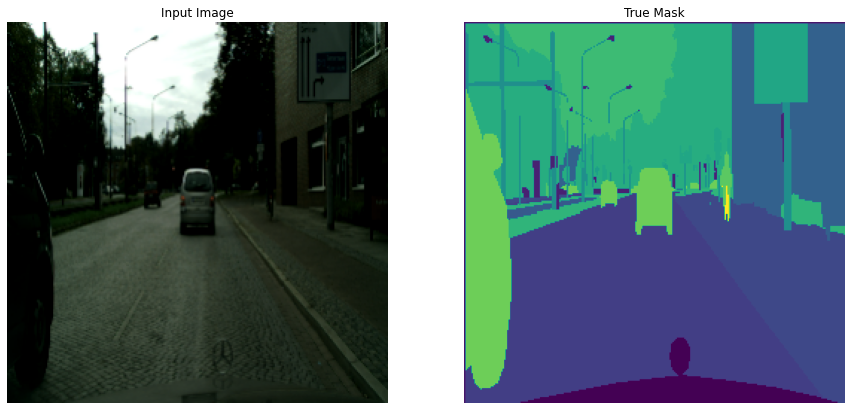

In [ ]:
for image, mask in train_dataset.take(1):
  sample_image, sample_mask = image, mask
image=sample_image[0]
mask=sample_mask[0]
display([image, mask])


In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

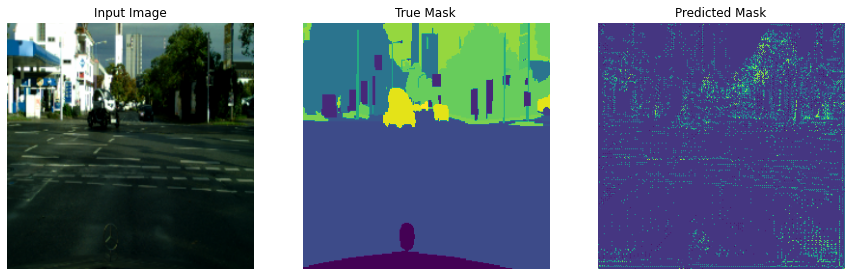

In [ ]:
show_predictions(train_dataset)

In [ ]:

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    # clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# class callbacktest(tf.keras.callbacks.Callback):
  
#   def on_batch_end(self, batch, logs=None):
#     # clear_output(wait=True)
#     # show_predictions()
#     print ('\n Fin batch Prediction after batch {}\n'.format(batch+1))

In [ ]:
optimizer = tf.keras.optimizers.Adam()

callbacks = [
    # Callback to interrupt the training if the validation loss stops improving:
    # tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_loss',
    #                                  restore_best_weights=True),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to save the model  specifying the epoch and val-loss in the filename:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'), save_freq=5),
    # Callback to print compacted metrics at the end of each epoch:


    # callback_simple_log,


    # Callback to log some validation results as image grids into TensorBoard:
    # callback_tb_grid
                ]

# unet_model.compile(optimizer=optimizer,
#                   #  loss=,
#                    loss='categorical_crossentropy',
#                   #  loss=tf.keras.losses.SparseCategoricalCrossentropy()  ,
#                     metrics=[SegmentationAccuracy(), SegmentationMeanIoU(num_classes)])
#               #  metrics=[tf.losses.CategoricalCrossentropy])

# opt = tf.keras.optimizers.Adam(lr=1e-9,clipvalue=0.01)
# unet_model.compile(optimizer=opt,
#               loss = 'sparse_categorical_crossentropy',
#                metrics = ['sparse_categorical_accuracy'])

####history

In [ ]:

optimizer = tf.keras.optimizers.Adam()
unet_model.compile(optimizer=optimizer, loss=SegmentationLoss(from_logits=False), 
                    # metrics=[SegmentationAccuracy(), SegmentationMeanIoU(num_classes)])
                  metrics = [tf.keras.metrics.sparse_categorical_accuracy])
                  # metrics=[SegmentationAccuracy(), SegmentationMeanIoU(num_classes)])



In [ ]:
history = unet_model.fit(
                  train_dataset,  
                  epochs=num_epochs, 
                  steps_per_epoch=train_steps_per_epoch,
                  validation_data=val_dataset, 
                  validation_steps=val_steps_per_epoch,
                  verbose=1,
                   callbacks=[DisplayCallback()])

Epoch 1/90
 23/186 [==>...........................] - ETA: 6:46 - loss: 3.4109 - sparse_categorical_accuracy: 0.2146

KeyboardInterrupt: ignored

In [ ]:
unet_model.summary()

#revisar la salida, debería de ser un vector con todas las clases en lugar de un numerito como lo tengo yo

(3, 128, 128, 20)
(3, 128, 128, 1)
(3, 128, 128, 20)
(49152, 20)
(49152, 3)
(3, 128, 128, 20)
(49152, 20)
(49152, 3)


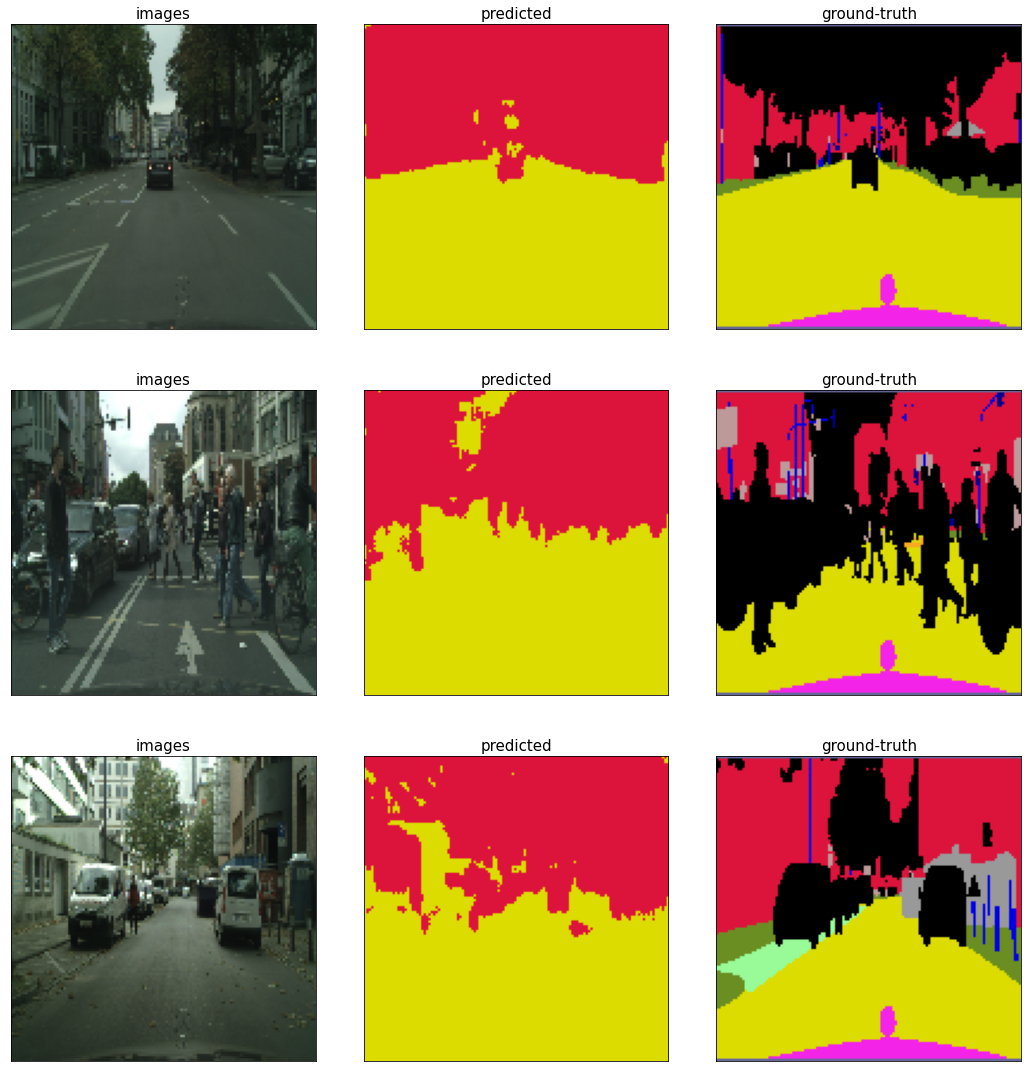

In [ ]:
image_show, predicted_show, gt_show = predict_and_postprocess(val_image_samples, val_gt_samples)

figure = plot_image_grid([image_show.numpy(), predicted_show.numpy(), gt_show.numpy()], 
                         titles=["images", "predicted", "ground-truth"])
figure.show()

testing

In [ ]:

for a, b in train_dataset.enumerate():
  print(a)
  print(b)
  break